# SCRIPT TO OBTAIN PHENOTIPIC QUANTITAVE TREATS

Quantitave traits taking all users: 
- Number of drug eras 
- Total drug exposures
- Treatment duration
- Cumulative gaps days
- Available medication days

Quantitave traits taking only users with certain targen diseases, to obtain this file you need to run first Target_diseases.ipynb to obtain the eids with the target diseases of interest, same traits as the previous.

Quantitave traits taking only long term users (>90 available medication days and not injectable or >=10 exposures not injectable) to obtain this file you need to run first omop_formulation.ipynb selecting the drugs of interest: 
- Total drug exposures
- Available medication days
- Proportion of Days Covered (PDC):
PDC = Available medication days/Treatment duration
- Medication Possession Ratio (MPR):
MPR = Total drug exposures not injectable /Treatment duration


The participants with no data on this fields: NA


## This script should only be run once

#### Initialization
##### Load packages

In [4]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import col, to_date

import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

##### Spark and dataset configuration 

In [ ]:
# Load the table
df = pd.read_csv("drug_era_atc.tsv", sep="\t")

# List of drugs to filter, write here the drug you are interested in
drugs_to_filter = ["morphine", "codeine"]

# Filter rows where the drug name is in the list of drugs to filter
filtered_df = df[df["concept_name"].isin(drugs_to_filter)]

# Select the required columns and rename _c13 to ATC
filtered_df = filtered_df[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01


In [ ]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df["ATC_First_Level"] = filtered_df["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df["ATC_Second_Level"] = filtered_df["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df["First_Level_Name"] = filtered_df["ATC_First_Level"].map(atc_1st_level)
filtered_df["Second_Level_Name"] = filtered_df["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04,R,R05,Respiratory System,Cough and Cold Preparations
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01,N,N02,Nervous System,Analgesics


In [ ]:
# Save the filtered table to a new file
filtered_df.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

In [ ]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

## All users QT phenotype

In [ ]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era'
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [ ]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[1201620, 1110410]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "dd/MM/yyyy"))

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|523986031867 |1201620        |2005-01-04         |2005-02-02       |1                  |0       |
|704374697810 |1201620        |2008-07-29         |2008-10-17       |2                  |22      |
|575525667834 |1201620        |2015-05-28         |2015-06-26       |1                  |0       |
|781684097755 |1201620        |2009-12-24         |2010-01-07       |1                  |0       |
|300647715760 |1201620        |1999-05-04         |1999-06-02       |1                  |0       |
|111669178968 |1201620        |1994-04-25         |1994-10-14       |6                  |15      |
|884763309279 |1201620        |2006-04-27         |2006-05-26       |2                  |0       |
|584115553

421762

In [ ]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

In [ ]:
display(pandas_df_era.drop("eid", axis=1))

,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,523986031867,1201620,2005-01-04,2005-02-02,1,0,codeine
1,704374697810,1201620,2008-07-29,2008-10-17,2,22,codeine
2,575525667834,1201620,2015-05-28,2015-06-26,1,0,codeine
3,781684097755,1201620,2009-12-24,2010-01-07,1,0,codeine
4,300647715760,1201620,1999-05-04,1999-06-02,1,0,codeine
...,...,...,...,...,...,...,...
421757,1176821060325,1201620,2011-11-02,2011-12-01,2,0,codeine
421758,627065239877,1201620,2015-03-13,2015-04-11,1,0,codeine
421759,910533081555,1201620,2008-04-22,2008-05-21,1,0,codeine
421760,438086665084,1110410,2015-02-03,2015-12-05,12,116,morphine


In [ ]:
# Load the CSV file as a DataFrame
data = pd.read_csv("filtered_data_era.csv")

Make exploratory analysis of the selected drugs

In [ ]:
data_morphine_codeine = data[(data["drug"] == "morphine") | (data["drug"] == "codeine")]

In [ ]:
data_morphine_codeine_sorted = data_morphine_codeine.sort_values(
    by="drug_era_start_date"
)
morphine_codeine = (
    data_morphine_codeine_sorted.groupby("eid")
    .agg(
        drugs=("drug", list),
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0]
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Function to calculate available medication days accounting for overlaps
def calculate_available_days(row):
    start_dates = row["start_dates_parsed"]
    end_dates = row["end_dates_parsed"]
    gap_days = row["gap_days"]

    intervals = sorted(zip(start_dates, end_dates, gap_days))

    total_days = 0
    last_end = None  # Track last end date for overlap detection

    for start, end, gap in intervals:
        duration = (end - start).days - gap

        if last_end is None or start > last_end:  # No overlap
            total_days += duration
        else:  # Overlap case
            overlap = (last_end - start).days
            effective_days = max(0, duration - overlap)  # Remove overlap
            total_days += effective_days

        last_end = max(last_end, end) if last_end else end  # Update last end date

    return total_days

In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_codeine["num_drug_era_id"].describe())

# Total exposures per participant
morphine_codeine["total_exposure_counts"] = morphine_codeine["exposure_counts"].apply(
    sum
)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_codeine["total_exposure_counts"].describe())

# Convert dates to datetime
morphine_codeine["start_dates_parsed"] = morphine_codeine["start_dates"].apply(
    lambda x: pd.to_datetime(x)
)
morphine_codeine["end_dates_parsed"] = morphine_codeine["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)

# Apply function to each row
morphine_codeine["available_medication_days"] = morphine_codeine.apply(
    calculate_available_days, axis=1
)
print("Summary of available_medication_days:")
print(morphine_codeine["available_medication_days"].describe())

# Calculate total_duration
morphine_codeine["total_duration"] = morphine_codeine.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)
print("Summary of total_duration:")
print(morphine_codeine["total_duration"].describe())

# Calculate duration_era
morphine_codeine["duration_era"] = morphine_codeine.apply(
    lambda row: [
        (end - start).days
        for start, end in zip(row["start_dates_parsed"], row["end_dates_parsed"])
    ],
    axis=1,
)

# Calculate gap_between_eras
morphine_codeine["gap_between_eras"] = morphine_codeine.apply(
    lambda row: [
        max((next_start - prev_end).days, 0)
        for prev_end, next_start in zip(
            row["end_dates_parsed"][:-1], row["start_dates_parsed"][1:]
        )
    ],
    axis=1,
)

# Calculate cumulative gap days (sum of all gaps between exposures and between eras)
morphine_codeine["cumulative_gap_days"] = morphine_codeine.apply(
    lambda row: sum(row["gap_days"]) + sum(row["gap_between_eras"])
    if isinstance(row["gap_days"], list) and isinstance(row["gap_between_eras"], list)
    else 0,
    axis=1,
)
print("\nSummary of cumulative_gap_days:")
print(morphine_codeine["cumulative_gap_days"].describe())

display(morphine_codeine.drop("eid", axis=1))

Summary of num_drug_era_id:
count    103449.000000
mean          4.077004
std           5.802804
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          99.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    103449.000000
mean         11.705159
std          29.789345
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        1015.000000
Name: total_exposure_counts, dtype: float64
Summary of available_medication_days:
count    103449.000000
mean        274.339443
std         646.236357
min           0.000000
25%          29.000000
50%          58.000000
75%         174.000000
max        9540.000000
Name: available_medication_days, dtype: float64
Summary of total_duration:
count    103449.000000
mean       1729.071214
std        2164.401467
min           0.000000
25%          29.000000
50%         664.000000
75%        3027.000000
max       10103.000000
Name: total_d

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,total_duration,duration_era,gap_between_eras,cumulative_gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,8,[8],[],0
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,331,"[29, 29]",[273],273
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,779,"[80, 33, 8]","[52, 606]",658
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,504,"[29, 30, 29, 29, 29, 29]","[78, 66, 57, 59, 69]",329
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,2381,"[4, 29, 29]","[1361, 958]",2319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,4544,"[29, 46, 29, 29, 84, 29, 29]","[952, 323, 2568, 250, 56, 120]",4295
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,1811,"[117, 29, 129, 29, 29, 29, 29, 29, 29, 29]","[72, 105, 229, 427, 195, 132, 49, 79, 45]",1396
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,5833,"[29, 29, 29, 29, 29]","[2015, 97, 1833, 1743]",5688
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,5402,"[29, 29, 159, 29, 82, 252, 70, 29]","[1322, 1158, 64, 171, 445, 1308, 255]",4836


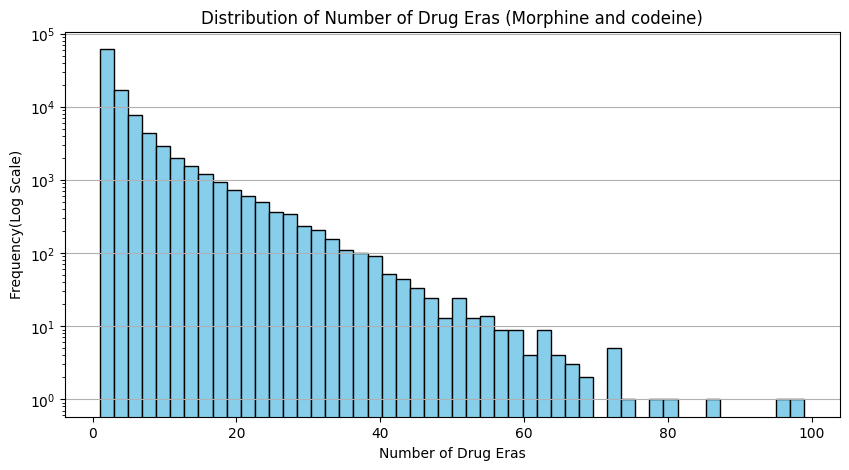

In [ ]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine and codeine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

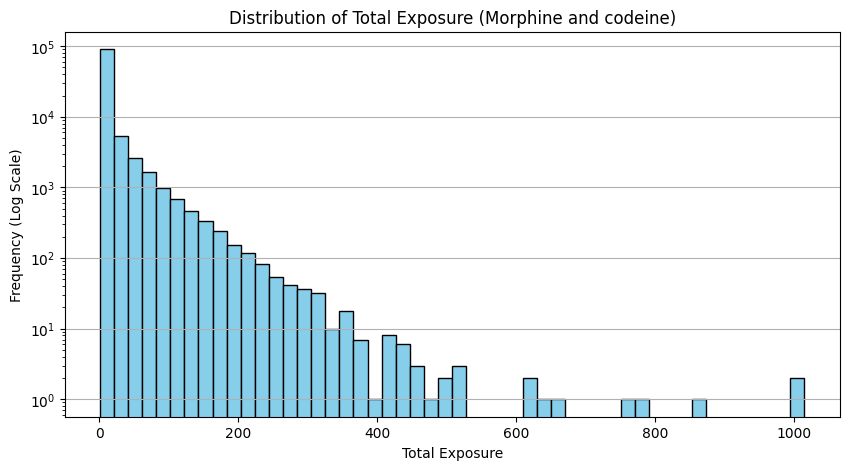

In [ ]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine and codeine)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

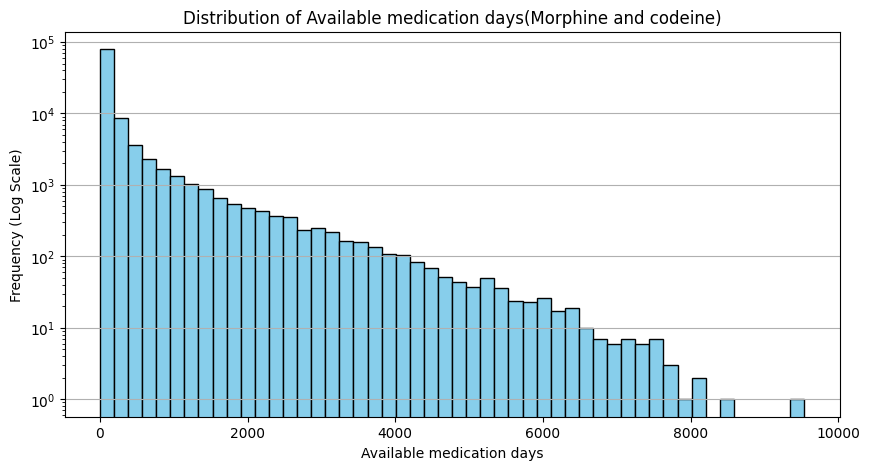

In [ ]:
# Visualize available medication days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine["available_medication_days"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Available medication days(Morphine and codeine)")
plt.xlabel("Available medication days")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

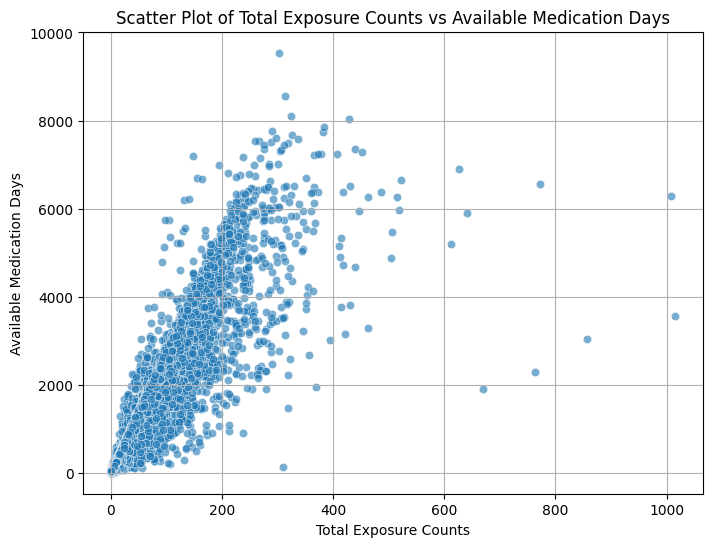

Pearson Correlation: 0.9362


In [ ]:
# Scatter plot total exposure counts vs available medication days
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=morphine_codeine["total_exposure_counts"],
    y=morphine_codeine["available_medication_days"],
    alpha=0.6,
)
plt.title("Scatter Plot of Total Exposure Counts vs Available Medication Days")
plt.xlabel("Total Exposure Counts")
plt.ylabel("Available Medication Days")
plt.grid(True)
plt.show()

# Compute correlation
correlation = morphine_codeine["total_exposure_counts"].corr(
    morphine_codeine["available_medication_days"]
)
print(f"Pearson Correlation: {correlation:.4f}")

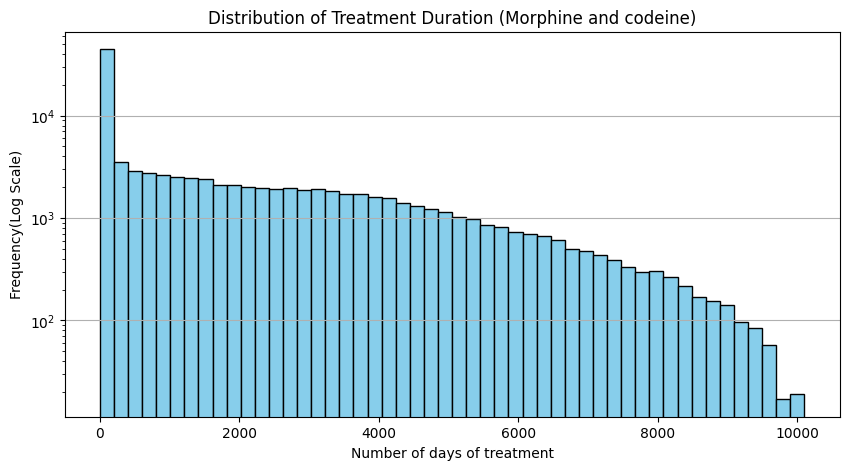

In [ ]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Morphine and codeine)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

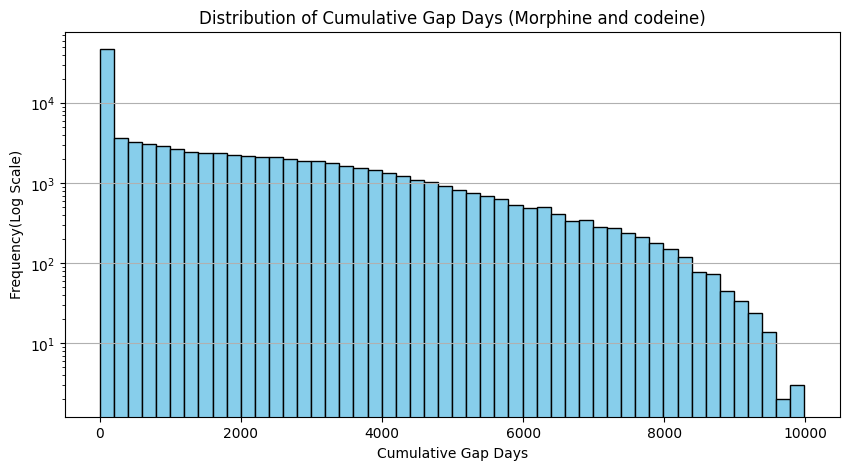

In [ ]:
# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (Morphine and codeine)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

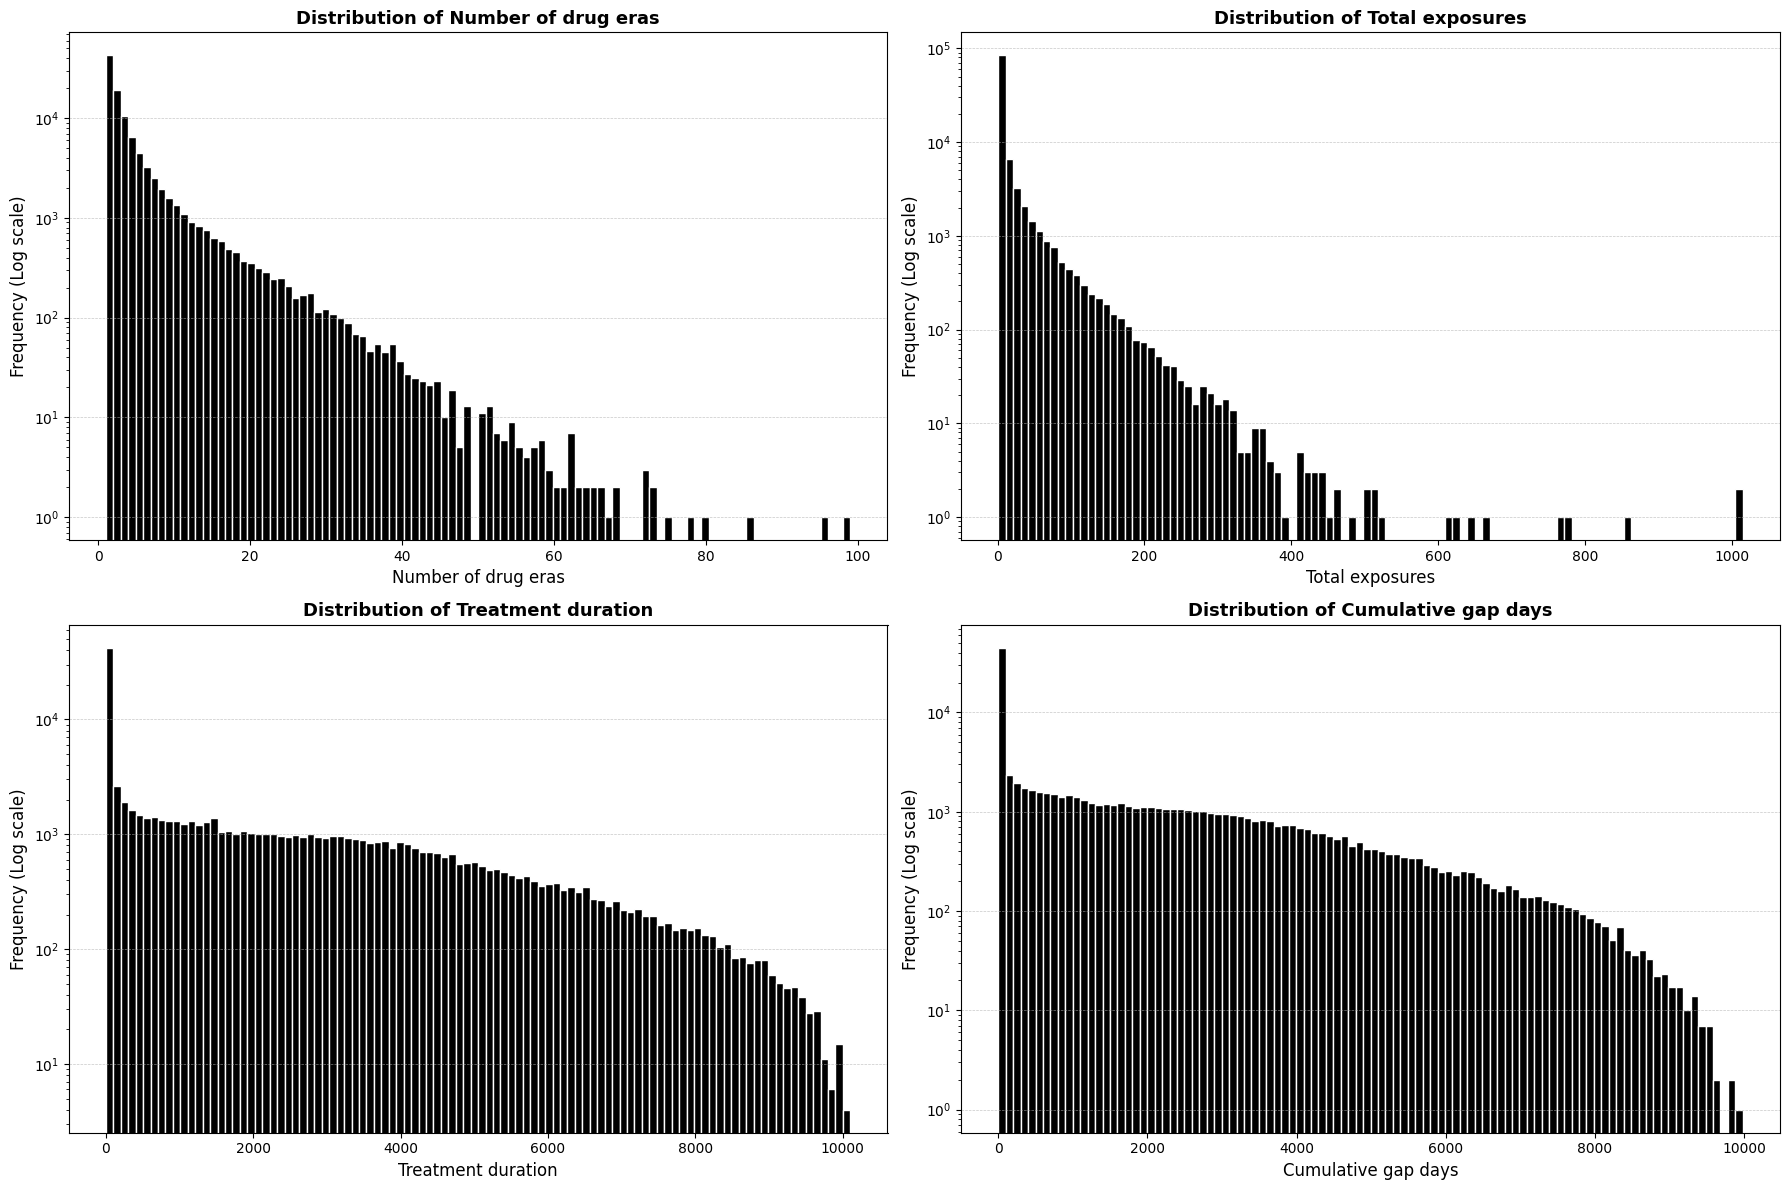

In [ ]:
# Set up 5 subplots (5 rows, 1 column)
# Set up 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False)

# Define plot settings
plot_configs = [
    ("num_drug_era_id", "Number of drug eras"),
    ("total_exposure_counts", "Total exposures"),
    ("total_duration", "Treatment duration"),
    ("cumulative_gap_days", "Cumulative gap days"),
]

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create each histogram
for ax, (column, title) in zip(axes, plot_configs):
    data = morphine_codeine[column].dropna()
    ax.hist(data, bins=100, color="black", edgecolor="white")
    ax.set_yscale("log")
    ax.set_title(f"Distribution of {title}", fontsize=13, fontweight="bold")
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel("Frequency (Log scale)", fontsize=12)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.tick_params(axis="both", labelsize=10)

plt.tight_layout()
plt.savefig(
    "combined_distribution_plots.png", dpi=300, bbox_inches="tight"
)  # Save as PNG
# plt.savefig("combined_distribution_plots.pdf", bbox_inches="tight")  # Optional PDF version

plt.show()

In [ ]:
num_unique_eids = morphine_codeine["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
morphine_codeine.to_csv("morphine_codeine_all_users_QT_phenotype.csv", index=False)
# Define the columns to keep
columns_to_keep = [
    "eid",
    "num_drug_era_id",
    "total_exposure_counts",
    "total_duration",
    "cumulative_gap_days",
    "available_medication_days",
]
# Load the phenotype CSV files into Pandas DataFrames
morphine_codeine_all_users_QT = pd.read_csv(
    "morphine_codeine_all_users_QT_phenotype.csv", usecols=columns_to_keep
)

Number of unique eids: 103449


### Keeping target diseases
Now from all these users we want to keep the ones with certain target diseases (Run Target_diseases.ipynb to obtain the list of eids). In this case we are keeping users that have been diagnosed with disease codes starting with M, keeping only the diseases diagnosed to > 1000 users.

In [ ]:
!dx download "500k WGS:/WGS_Lucia/Data/phenotypes/unique_eids_target_diseases_M_1000_eids.txt"

[===========================================================>] Completed 98,544 of 98,544 bytes (100%) /opt/notebooks/unique_eids_target_diseases_M_1000_eids.txtt


In [ ]:
# Keep target diseases
unique_eids_target_diseases_M_1000_eids = np.loadtxt(
    "unique_eids_target_diseases_M_1000_eids.txt", dtype=int
)
# Filter the DataFrame
morphine_codeine_target_diseases = morphine_codeine[
    morphine_codeine["eid"].astype(int).isin(unique_eids_target_diseases_M_1000_eids)
]
num_unique_eids = morphine_codeine_target_diseases["eid"].nunique()
print("Number of unique eids:", num_unique_eids)

Number of unique eids: 12318


In [ ]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_codeine_target_diseases["num_drug_era_id"].describe())

# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_codeine_target_diseases["total_exposure_counts"].describe())

# Analyze total available medication days
print("Summary of available_medication_days:")
print(morphine_codeine_target_diseases["available_medication_days"].describe())

# Analyze total_duration
print("Summary of total_duration:")
print(morphine_codeine_target_diseases["total_duration"].describe())

# Analyze cumulative gap days (sum of all gaps between exposures and between eras)
print("\nSummary of cumulative_gap_days:")
print(morphine_codeine_target_diseases["cumulative_gap_days"].describe())

display(morphine_codeine_target_diseases.drop("eid", axis=1))

Summary of num_drug_era_id:
count    12318.000000
mean         8.988310
std          8.556999
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max         75.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    12318.000000
mean        39.623721
std         57.721330
min          1.000000
25%          6.000000
50%         17.000000
75%         51.000000
max       1015.000000
Name: total_exposure_counts, dtype: float64
Summary of available_medication_days:
count    12318.000000
mean       892.812064
std       1164.020829
min          1.000000
25%        127.000000
50%        387.000000
75%       1217.000000
max       8563.000000
Name: available_medication_days, dtype: float64
Summary of total_duration:
count    12318.000000
mean      3331.988310
std       2380.373054
min          1.000000
25%       1315.250000
50%       3177.500000
75%       4996.750000
max      10076.000000
Name: total_duration, dtype: float64

Summary

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,total_duration,duration_era,gap_between_eras,cumulative_gap_days
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,779,"[80, 33, 8]","[52, 606]",658
7,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2013-08-23, 2013-12-17, 2014-04-07, 2014-09-0...","[2013-11-12, 2014-01-15, 2014-07-05, 2014-10-2...","[2, 1, 3, 2, 2, 1]","[23, 0, 8, 0, 30, 0]",11,"DatetimeIndex(['2013-08-23', '2013-12-17', '20...","DatetimeIndex(['2013-11-12', '2014-01-15', '20...",306,651,"[81, 29, 89, 51, 88, 29]","[35, 82, 61, 41, 65]",345
9,"[codeine, codeine, codeine, codeine, morphine,...",8,"[2003-07-21, 2003-11-24, 2004-06-04, 2005-07-2...","[2003-08-19, 2004-03-18, 2005-06-21, 2005-08-2...","[1, 4, 20, 1, 1, 7, 72, 37]","[0, 20, 22, 0, 0, 20, 96, 80]",143,"DatetimeIndex(['2003-07-21', '2003-11-24', '20...","DatetimeIndex(['2003-08-19', '2004-03-18', '20...",3390,5077,"[29, 115, 382, 29, 11, 148, 1897, 1017]","[97, 78, 34, 1073, 2, 110, 55]",1687
23,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2000-08-14, 2007-03-16, 2008-08-15, 2009-05-1...","[2000-11-23, 2007-04-14, 2009-04-13, 2011-07-1...","[3, 1, 10, 28, 1, 7]","[28, 0, 101, 138, 0, 32]",50,"DatetimeIndex(['2000-08-14', '2007-03-16', '20...","DatetimeIndex(['2000-11-23', '2007-04-14', '20...",1125,5798,"[101, 29, 241, 788, 33, 232]","[2304, 489, 32, 540, 1009]",4673
26,[codeine],1,[2016-01-27],[2016-03-11],[2],[0],2,"DatetimeIndex(['2016-01-27'], dtype='datetime6...","DatetimeIndex(['2016-03-11'], dtype='datetime6...",44,44,[44],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103417,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2004-05-28, 2004-09-16, 2004-12-07, 2005-04-1...","[2004-07-31, 2004-10-15, 2005-03-04, 2005-07-0...","[2, 1, 3, 2, 4, 1, 1, 2, 106, 15]","[6, 0, 16, 27, 68, 0, 0, 16, 377, 14]",137,"DatetimeIndex(['2004-05-28', '2004-09-16', '20...","DatetimeIndex(['2004-07-31', '2004-10-15', '20...",3698,4855,"[64, 29, 87, 85, 184, 29, 29, 74, 3269, 372]","[47, 53, 42, 53, 54, 84, 217, 49, 34]",1157
103418,"[codeine, codeine, codeine, codeine, codeine, ...",17,"[1999-04-26, 2003-09-15, 2004-01-23, 2006-10-0...","[1999-05-25, 2003-10-14, 2004-02-21, 2006-11-0...","[1, 1, 1, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 5, 4, ...","[0, 0, 0, 0, 5, 30, 24, 0, 0, 0, 0, 0, 0, 33, ...",89,"DatetimeIndex(['1999-04-26', '2003-09-15', '20...","DatetimeIndex(['1999-05-25', '2003-10-14', '20...",2383,6283,"[29, 29, 29, 29, 86, 133, 82, 29, 29, 29, 29, ...","[1574, 101, 955, 106, 66, 97, 96, 139, 62, 90,...",3900
103430,"[codeine, codeine, codeine, codeine, codeine]",5,"[2004-11-02, 2005-06-27, 2006-09-13, 2007-07-1...","[2005-02-08, 2005-07-26, 2006-11-09, 2007-08-1...","[3, 1, 2, 1, 1]","[11, 0, 0, 0, 0]",8,"DatetimeIndex(['2004-11-02', '2005-06-27', '20...","DatetimeIndex(['2005-02-08', '2005-07-26', '20...",231,3697,"[98, 29, 57, 29, 29]","[139, 414, 251, 2651]",3466
103434,"[codeine, codeine, codeine]",3,"[2011-02-23, 2014-03-20, 2015-05-29]","[2011-04-12, 2014-08-12, 2015-09-16]","[2, 4, 3]","[0, 35, 25]",9,"DatetimeIndex(['2011-02-23', '2014-03-20', '20...","DatetimeIndex(['2011-04-12', '2014-08-12', '20...",243,1666,"[48, 145, 110]","[1073, 290]",1423


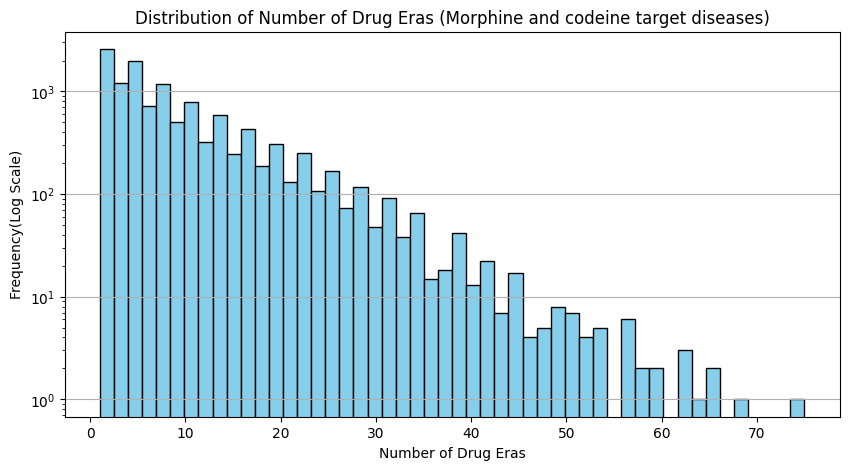

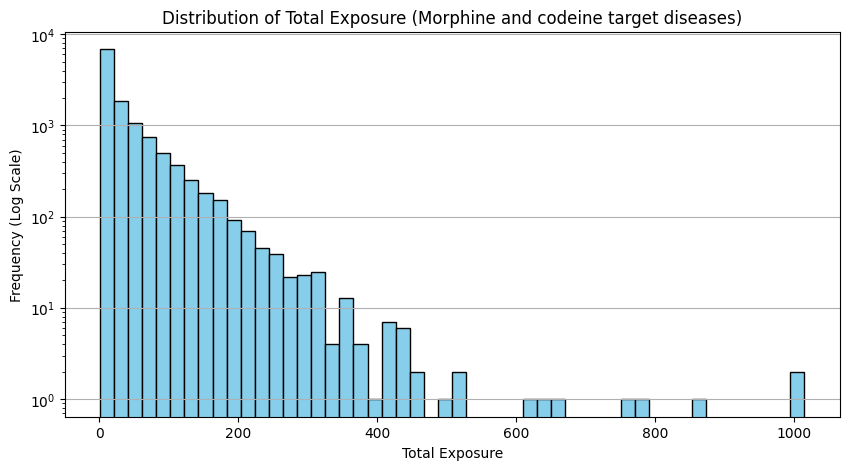

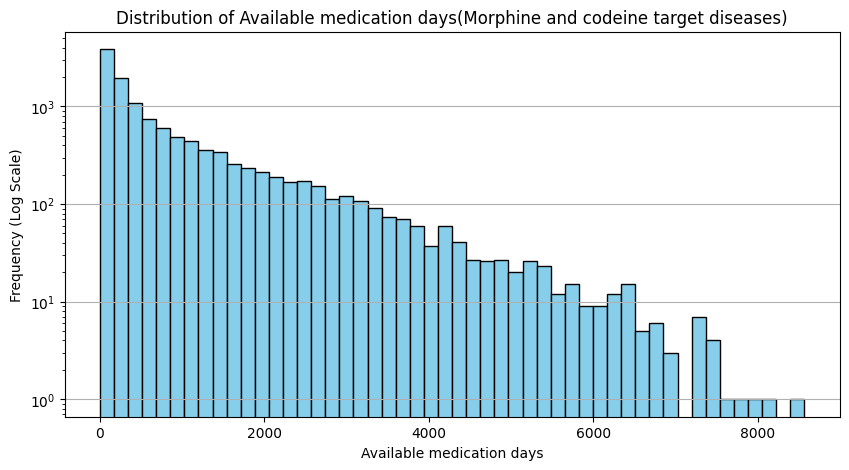

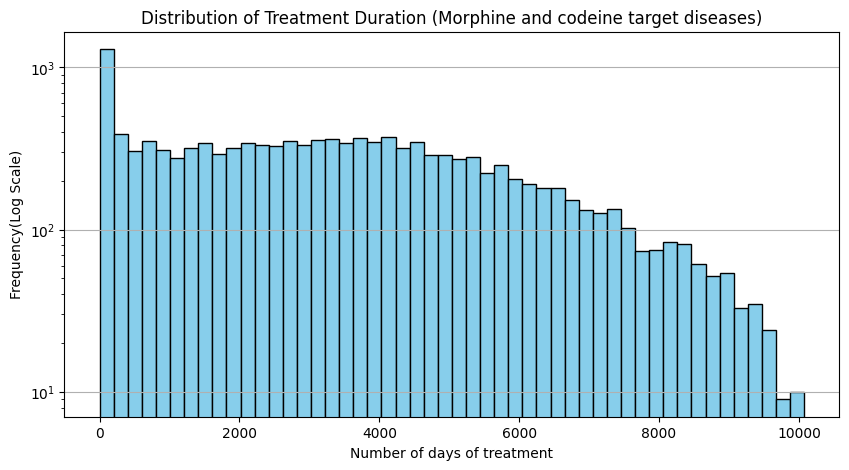

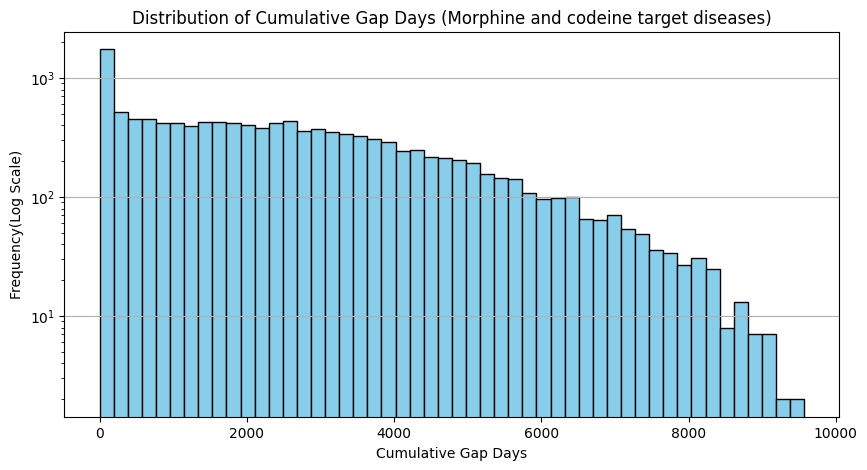

In [ ]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_target_diseases["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine and codeine target diseases)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_target_diseases["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine and codeine target diseases)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

# Visualize available medication days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_target_diseases["available_medication_days"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title(
    "Distribution of Available medication days(Morphine and codeine target diseases)"
)
plt.xlabel("Available medication days")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
plt.show()

# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_target_diseases["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Morphine and codeine target diseases)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

# Visualize cumulative gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_target_diseases["cumulative_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Cumulative Gap Days (Morphine and codeine target diseases)")
plt.xlabel("Cumulative Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

In [ ]:
morphine_codeine_target_diseases.to_csv(
    "morphine_codeine_target_diseases_users_QT_phenotype.csv", index=False
)
# Define the columns to keep
columns_to_keep = [
    "eid",
    "num_drug_era_id",
    "total_exposure_counts",
    "total_duration",
    "cumulative_gap_days",
    "available_medication_days",
]
# Load the phenotype CSV files into Pandas DataFrames
morphine_codeine_target_diseases_users_QT = pd.read_csv(
    "morphine_codeine_target_diseases_users_QT_phenotype.csv", usecols=columns_to_keep
)

## Long term users QT phenotype (>90 available medication days)
Now we will define the phenotypes for long term users (First remove injectable exposures and the filter individuals with >90 available medication days) calculation 2 adherence scores. 
To remove injectable exposures we need first to run the 'omop_formulation.ipynb' notebook indicating the drugs of interest

In [ ]:
# Specify the columns you want to read
columns_of_interest = [
    "eid",
    "drug_era_id",
    "drug_concept_id",
    "drug_era_start_date",
    "drug_era_end_date",
    "gap_days",
    "drug_name",
    "exposures_not_injectable",
]
# Read only those columns from the file
morphine_codeine_formulation = pd.read_csv(
    "morphine_codeine_without_injectable_formulation.tsv",
    sep="\t",
    usecols=columns_of_interest,
)

morphine_codeine_formulation = morphine_codeine_formulation.sort_values(
    by="drug_era_start_date"
)
morphine_codeine_formulation = (
    morphine_codeine_formulation.groupby("eid")
    .agg(
        drugs=("drug_name", list),
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposures_not_injectable=("exposures_not_injectable", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_codeine_formulation.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposures_not_injectable,gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0]
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103197,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103198,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103199,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103200,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Total exposures per participant
morphine_codeine_formulation["total_exposures_not_injectable"] = (
    morphine_codeine_formulation["exposures_not_injectable"].apply(sum)
)

# Convert dates to datetime
morphine_codeine_formulation["start_dates_parsed"] = morphine_codeine_formulation[
    "start_dates"
].apply(lambda x: pd.to_datetime(x))
morphine_codeine_formulation["end_dates_parsed"] = morphine_codeine_formulation[
    "end_dates"
].apply(lambda x: pd.to_datetime(x))

# Apply function to calculate available medication days each row
morphine_codeine_formulation["available_medication_days"] = (
    morphine_codeine_formulation.apply(calculate_available_days, axis=1)
)

# Calculate total_duration
morphine_codeine_formulation["total_duration"] = morphine_codeine_formulation.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)

In [ ]:
# Filter rows where available medication days is > 90 days
morphine_codeine_long_term = morphine_codeine_formulation[
    morphine_codeine_formulation["available_medication_days"] > 90
].copy()
# Add new columns
morphine_codeine_long_term["PDC_adherence_score"] = (
    morphine_codeine_long_term["available_medication_days"]
    / morphine_codeine_long_term["total_duration"]
)
# Analyze PDC adherence score
print("\nSummary of PDC_adherence_score")
print(morphine_codeine_long_term["PDC_adherence_score"].describe())

morphine_codeine_long_term["MPR_adherence_score"] = (
    morphine_codeine_long_term["total_exposures_not_injectable"]
    / morphine_codeine_long_term["total_duration"]
)
# Analyze MPR adherence score
print("\nSummary of MPR_adherence_score")
print(morphine_codeine_long_term["MPR_adherence_score"].describe())


display(morphine_codeine_long_term.drop("eid", axis=1))


Summary of PDC_adherence_score
count    37757.000000
mean         0.246744
std          0.249492
min          0.009777
25%          0.058434
50%          0.140202
75%          0.365040
max          1.000000
Name: PDC_adherence_score, dtype: float64

Summary of MPR_adherence_score
count    37757.000000
mean         0.010882
std          0.013469
min          0.000308
25%          0.002342
50%          0.005703
75%          0.014818
max          0.302671
Name: MPR_adherence_score, dtype: float64


,drugs,num_drug_era_id,start_dates,end_dates,exposures_not_injectable,gap_days,total_exposures_not_injectable,start_dates_parsed,end_dates_parsed,available_medication_days,total_duration,PDC_adherence_score,MPR_adherence_score
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,779,0.155327,0.010270
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,504,0.347222,0.013889
7,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2013-08-23, 2013-12-17, 2014-04-07, 2014-09-0...","[2013-11-12, 2014-01-15, 2014-07-05, 2014-10-2...","[2, 1, 3, 2, 2, 1]","[23, 0, 8, 0, 30, 0]",11,"DatetimeIndex(['2013-08-23', '2013-12-17', '20...","DatetimeIndex(['2013-11-12', '2014-01-15', '20...",306,651,0.470046,0.016897
9,"[codeine, codeine, codeine, codeine, morphine,...",8,"[2003-07-21, 2003-11-24, 2004-06-04, 2005-07-2...","[2003-08-19, 2004-03-18, 2005-06-21, 2005-08-2...","[1, 4, 20, 1, 1, 7, 72, 37]","[0, 20, 22, 0, 0, 20, 96, 80]",143,"DatetimeIndex(['2003-07-21', '2003-11-24', '20...","DatetimeIndex(['2003-08-19', '2004-03-18', '20...",3390,5077,0.667717,0.028166
10,"[codeine, codeine, codeine]",3,"[2011-08-22, 2011-12-28, 2012-07-02]","[2011-09-21, 2012-01-26, 2017-05-31]","[2, 1, 66]","[0, 0, 884]",69,"DatetimeIndex(['2011-08-22', '2011-12-28', '20...","DatetimeIndex(['2011-09-21', '2012-01-26', '20...",969,2109,0.459459,0.032717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103191,"[codeine, codeine, codeine, codeine]",4,"[2002-07-31, 2013-05-28, 2013-09-09, 2013-12-10]","[2002-08-29, 2013-06-26, 2013-10-08, 2014-01-08]","[1, 1, 1, 1]","[0, 0, 0, 0]",4,"DatetimeIndex(['2002-07-31', '2013-05-28', '20...","DatetimeIndex(['2002-08-29', '2013-06-26', '20...",116,4179,0.027758,0.000957
103197,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,4544,0.054798,0.001981
103198,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,1811,0.229155,0.008283
103199,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,5833,0.024859,0.000857


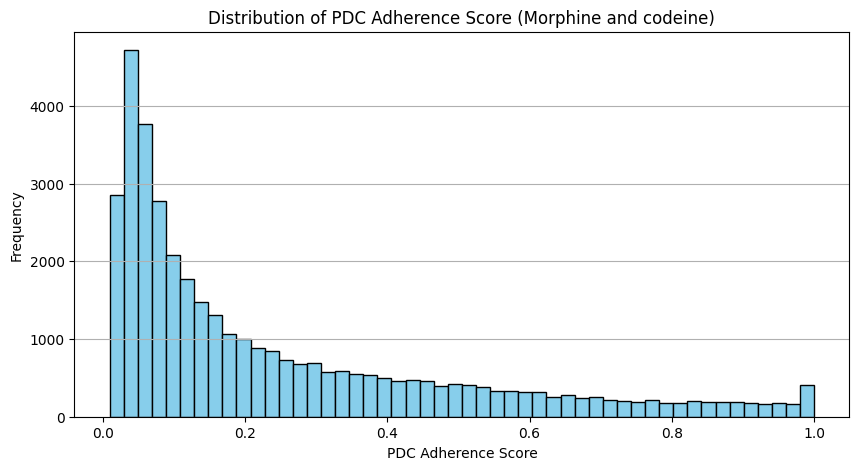

In [ ]:
# Visualize PDC adherence score
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_long_term["PDC_adherence_score"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of PDC Adherence Score (Morphine and codeine)")
plt.xlabel("PDC Adherence Score")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

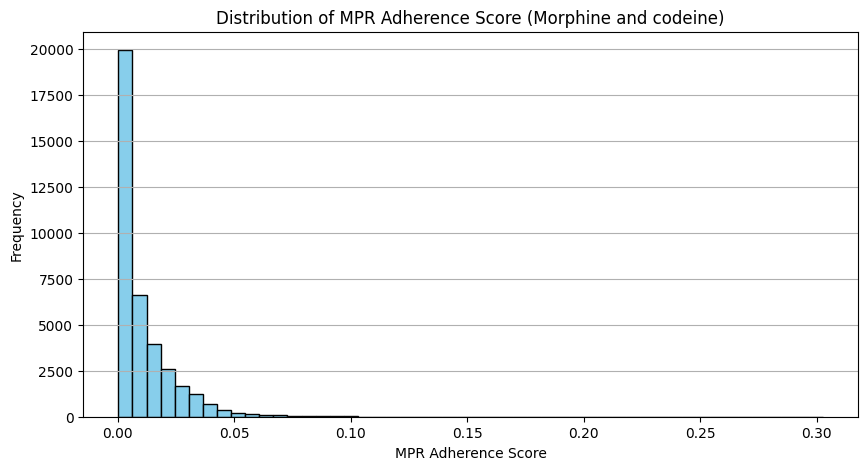

In [ ]:
# Visualize MPR adherence score
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_long_term["MPR_adherence_score"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of MPR Adherence Score (Morphine and codeine)")
plt.xlabel("MPR Adherence Score")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

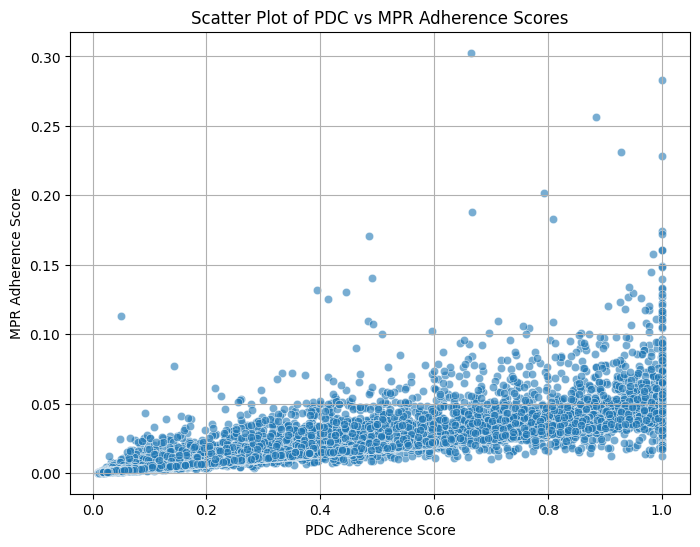

Pearson Correlation: 0.8639


In [ ]:
# Scatter plot PDC vs MPR adherence scores
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=morphine_codeine_long_term["PDC_adherence_score"],
    y=morphine_codeine_long_term["MPR_adherence_score"],
    alpha=0.6,
)
plt.title("Scatter Plot of PDC vs MPR Adherence Scores")
plt.xlabel("PDC Adherence Score")
plt.ylabel("MPR Adherence Score")
plt.grid(True)
plt.show()
# Compute correlation
correlation = morphine_codeine_long_term["PDC_adherence_score"].corr(
    morphine_codeine_long_term["MPR_adherence_score"]
)
print(f"Pearson Correlation: {correlation:.4f}")

In [ ]:
num_unique_eids = morphine_codeine_long_term["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
# Now save the long term users QT file
morphine_codeine_long_term.to_csv(
    "morphine_codeine_long_term_users_QT_phenotype.csv", index=False
)

Number of unique eids: 37757


In [ ]:
# Define the columns to keep
columns_to_keep = [
    "eid",
    "total_exposures_not_injectable",
    "available_medication_days",
    "PDC_adherence_score",
    "MPR_adherence_score",
]
# Load the phenotype CSV files into Pandas DataFrames
morphine_codeine_long_term_users_QT = pd.read_csv(
    "morphine_codeine_long_term_users_QT_phenotype.csv", usecols=columns_to_keep
)

In [ ]:
unique_eids_target_diseases_M_1000_eids = np.loadtxt(
    "unique_eids_target_diseases_M_1000_eids.txt", dtype=int
)
# Filter the DataFrame
morphine_codeine_long_term_target_diseases = morphine_codeine_long_term[
    morphine_codeine_long_term["eid"]
    .astype(int)
    .isin(unique_eids_target_diseases_M_1000_eids)
]

In [ ]:
num_unique_eids = morphine_codeine_long_term_target_diseases["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
morphine_codeine_long_term_target_diseases.to_csv(
    "morphine_codeine_long_term_target_diseases_users_QT_phenotype.csv", index=False
)

In [ ]:
# Define the columns to keep
columns_to_keep = [
    "eid",
    "total_exposures_not_injectable",
    "available_medication_days",
    "PDC_adherence_score",
    "MPR_adherence_score",
]
# Load the phenotype CSV files into Pandas DataFrames
morphine_codeine_long_term_target_diseases_users_QT = pd.read_csv(
    "morphine_codeine_long_term_target_diseases_users_QT_phenotype.csv",
    usecols=columns_to_keep,
)

## Long term users QT phenotype (>=10 not injectable exposures)
Now we will define the phenotypes for long term users (First remove injectable exposures and the filter individuals with >=10 exposures) calculation 2 adherence scores. 
To remove injectable exposures we need first to run the 'omop_formulation.ipynb' notebook indicating the drugs of interest

In [ ]:
# Specify the columns you want to read
columns_of_interest = [
    "eid",
    "drug_era_id",
    "drug_concept_id",
    "drug_era_start_date",
    "drug_era_end_date",
    "gap_days",
    "drug_name",
    "exposures_not_injectable",
]
# Read only those columns from the file
morphine_codeine_formulation = pd.read_csv(
    "morphine_codeine_without_injectable_formulation.tsv",
    sep="\t",
    usecols=columns_of_interest,
)

morphine_codeine_formulation = morphine_codeine_formulation.sort_values(
    by="drug_era_start_date"
)
morphine_codeine_formulation = (
    morphine_codeine_formulation.groupby("eid")
    .agg(
        drugs=("drug_name", list),
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposures_not_injectable=("exposures_not_injectable", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_codeine_formulation.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposures_not_injectable,gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0]
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103197,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103198,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103199,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103200,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Total exposures per participant
morphine_codeine_formulation["total_exposures_not_injectable"] = (
    morphine_codeine_formulation["exposures_not_injectable"].apply(sum)
)

# Convert dates to datetime
morphine_codeine_formulation["start_dates_parsed"] = morphine_codeine_formulation[
    "start_dates"
].apply(lambda x: pd.to_datetime(x))
morphine_codeine_formulation["end_dates_parsed"] = morphine_codeine_formulation[
    "end_dates"
].apply(lambda x: pd.to_datetime(x))

# Apply function to calculate available medication days each row
morphine_codeine_formulation["available_medication_days"] = (
    morphine_codeine_formulation.apply(calculate_available_days, axis=1)
)

# Calculate total_duration
morphine_codeine_formulation["total_duration"] = morphine_codeine_formulation.apply(
    lambda row: (max(row["end_dates_parsed"]) - min(row["start_dates_parsed"])).days,
    axis=1,
)

In [ ]:
# Filter rows where total exposures is > 10
morphine_codeine_long_term = morphine_codeine_formulation[
    morphine_codeine_formulation["total_exposures_not_injectable"] >= 10
].copy()
# Add new columns
morphine_codeine_long_term["PDC_adherence_score"] = (
    morphine_codeine_long_term["available_medication_days"]
    / morphine_codeine_long_term["total_duration"]
)
# Analyze PDC adherence score
print("\nSummary of PDC_adherence_score")
print(morphine_codeine_long_term["PDC_adherence_score"].describe())

morphine_codeine_long_term["MPR_adherence_score"] = (
    morphine_codeine_long_term["total_exposures_not_injectable"]
    / morphine_codeine_long_term["total_duration"]
)
# Analyze MPR adherence score
print("\nSummary of MPR_adherence_score")
print(morphine_codeine_long_term["MPR_adherence_score"].describe())


display(morphine_codeine_long_term.drop("eid", axis=1))


Summary of PDC_adherence_score
count    21678.000000
mean         0.324749
std          0.249892
min          0.009432
25%          0.118606
50%          0.249334
75%          0.478120
max          1.000000
Name: PDC_adherence_score, dtype: float64

Summary of MPR_adherence_score
count    21678.000000
mean         0.014773
std          0.015135
min          0.001068
25%          0.004981
50%          0.010277
75%          0.019762
max          0.302671
Name: MPR_adherence_score, dtype: float64


,drugs,num_drug_era_id,start_dates,end_dates,exposures_not_injectable,gap_days,total_exposures_not_injectable,start_dates_parsed,end_dates_parsed,available_medication_days,total_duration,PDC_adherence_score,MPR_adherence_score
7,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2013-08-23, 2013-12-17, 2014-04-07, 2014-09-0...","[2013-11-12, 2014-01-15, 2014-07-05, 2014-10-2...","[2, 1, 3, 2, 2, 1]","[23, 0, 8, 0, 30, 0]",11,"DatetimeIndex(['2013-08-23', '2013-12-17', '20...","DatetimeIndex(['2013-11-12', '2014-01-15', '20...",306,651,0.470046,0.016897
9,"[codeine, codeine, codeine, codeine, morphine,...",8,"[2003-07-21, 2003-11-24, 2004-06-04, 2005-07-2...","[2003-08-19, 2004-03-18, 2005-06-21, 2005-08-2...","[1, 4, 20, 1, 1, 7, 72, 37]","[0, 20, 22, 0, 0, 20, 96, 80]",143,"DatetimeIndex(['2003-07-21', '2003-11-24', '20...","DatetimeIndex(['2003-08-19', '2004-03-18', '20...",3390,5077,0.667717,0.028166
10,"[codeine, codeine, codeine]",3,"[2011-08-22, 2011-12-28, 2012-07-02]","[2011-09-21, 2012-01-26, 2017-05-31]","[2, 1, 66]","[0, 0, 884]",69,"DatetimeIndex(['2011-08-22', '2011-12-28', '20...","DatetimeIndex(['2011-09-21', '2012-01-26', '20...",969,2109,0.459459,0.032717
18,"[codeine, codeine, codeine, codeine, codeine]",5,"[2007-11-05, 2008-02-27, 2008-08-18, 2014-01-2...","[2007-12-29, 2008-03-27, 2009-02-06, 2014-02-2...","[3, 1, 7, 1, 1]","[0, 0, 21, 0, 0]",13,"DatetimeIndex(['2007-11-05', '2008-02-27', '20...","DatetimeIndex(['2007-12-29', '2008-03-27', '20...",292,2993,0.097561,0.004343
21,"[codeine, codeine, codeine, codeine, codeine, ...",33,"[1995-10-13, 1997-10-01, 1997-12-31, 1998-04-0...","[1995-11-11, 1997-10-30, 1998-01-29, 1998-05-0...","[1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 27, 21, 28, 0, 0, 0, 0, 0, 0, 0, ...",74,"DatetimeIndex(['1995-10-13', '1997-10-01', '19...","DatetimeIndex(['1995-11-11', '1997-10-30', '19...",1771,7528,0.235255,0.009830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103171,"[codeine, codeine, codeine, codeine, codeine, ...",17,"[1999-04-26, 2003-09-15, 2004-01-23, 2006-10-0...","[1999-05-25, 2003-10-14, 2004-02-21, 2006-11-0...","[1, 1, 1, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 5, 4, ...","[0, 0, 0, 0, 5, 30, 24, 0, 0, 0, 0, 0, 0, 33, ...",89,"DatetimeIndex(['1999-04-26', '2003-09-15', '20...","DatetimeIndex(['1999-05-25', '2003-10-14', '20...",2383,6283,0.379277,0.014165
103180,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2004-08-06, 2004-10-07, 2005-07-06, 2005-12-1...","[2004-09-04, 2005-03-08, 2005-09-30, 2006-02-0...","[1, 5, 2, 2, 1, 3, 1, 2]","[0, 19, 28, 0, 0, 5, 0, 0]",17,"DatetimeIndex(['2004-08-06', '2004-10-07', '20...","DatetimeIndex(['2004-09-04', '2005-03-08', '20...",459,2841,0.161563,0.005984
103190,"[codeine, codeine, codeine, codeine, codeine, ...",18,"[1997-05-22, 1998-02-11, 1998-04-14, 1998-10-1...","[1997-06-20, 1998-03-12, 1998-05-13, 1998-11-1...","[1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 1, 9, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 16, 0, 0, 42, ...",59,"DatetimeIndex(['1997-05-22', '1998-02-11', '19...","DatetimeIndex(['1997-06-20', '1998-03-12', '19...",1519,6124,0.248040,0.009634
103198,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,1811,0.229155,0.008283


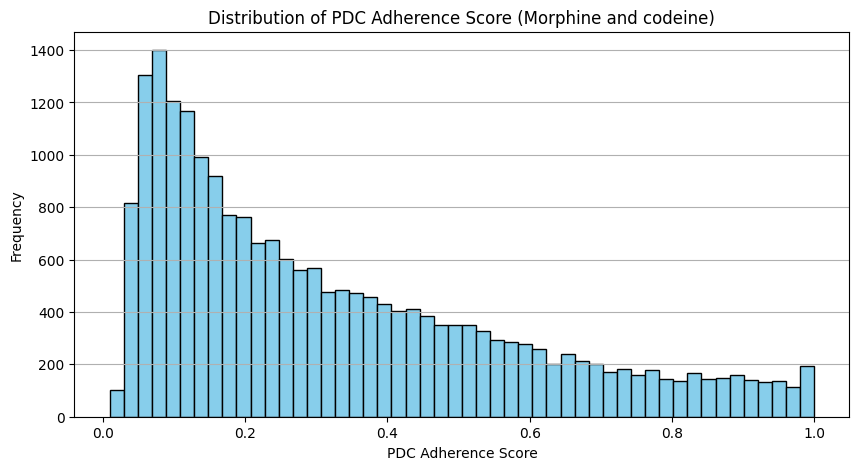

In [ ]:
# Visualize PDC adherence score
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_long_term["PDC_adherence_score"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of PDC Adherence Score (Morphine and codeine)")
plt.xlabel("PDC Adherence Score")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

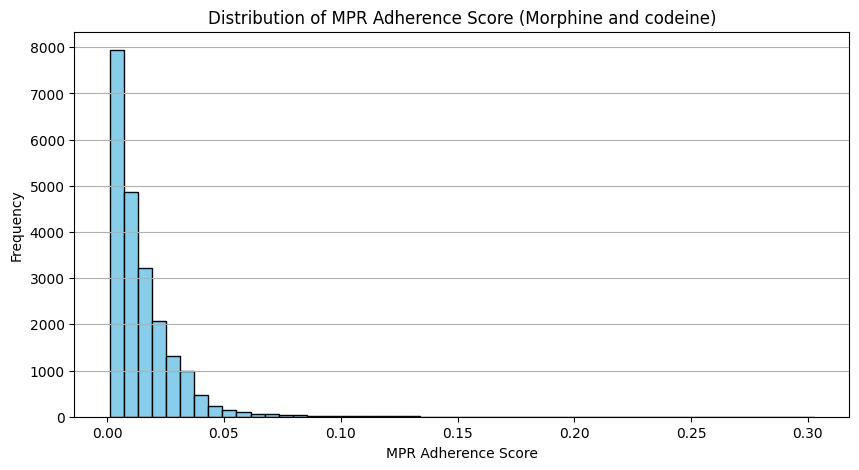

In [ ]:
# Visualize MPR adherence score
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_codeine_long_term["MPR_adherence_score"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of MPR Adherence Score (Morphine and codeine)")
plt.xlabel("MPR Adherence Score")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

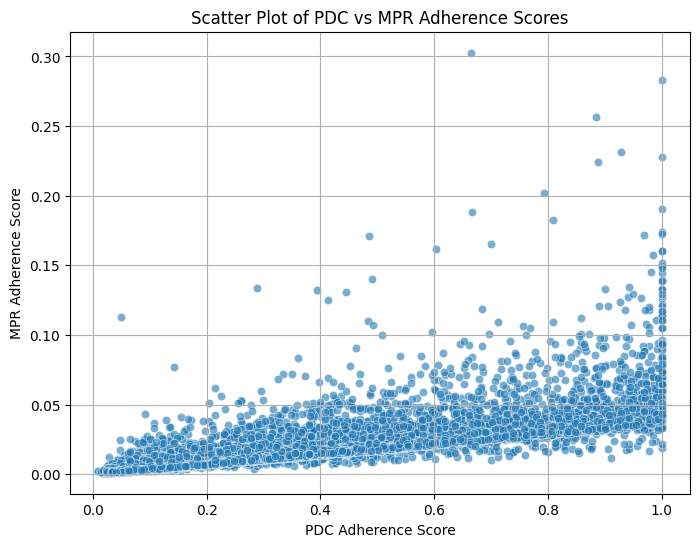

Pearson Correlation: 0.7967


In [ ]:
# Scatter plot PDC vs MPR adherence scores
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=morphine_codeine_long_term["PDC_adherence_score"],
    y=morphine_codeine_long_term["MPR_adherence_score"],
    alpha=0.6,
)
plt.title("Scatter Plot of PDC vs MPR Adherence Scores")
plt.xlabel("PDC Adherence Score")
plt.ylabel("MPR Adherence Score")
plt.grid(True)
plt.show()
# Compute correlation
correlation = morphine_codeine_long_term["PDC_adherence_score"].corr(
    morphine_codeine_long_term["MPR_adherence_score"]
)
print(f"Pearson Correlation: {correlation:.4f}")

In [ ]:
num_unique_eids = morphine_codeine_long_term["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
# Now save the long term users QT file
morphine_codeine_long_term.to_csv(
    "morphine_codeine_long_term_exposures_users_QT_phenotype.csv", index=False
)

Number of unique eids: 21678


In [ ]:
# Define the columns to keep
columns_to_keep = [
    "eid",
    "total_exposures_not_injectable",
    "available_medication_days",
    "PDC_adherence_score",
    "MPR_adherence_score",
]
# Load the phenotype CSV files into Pandas DataFrames
morphine_codeine_long_term_exposures_users_QT = pd.read_csv(
    "morphine_codeine_long_term_exposures_users_QT_phenotype.csv",
    usecols=columns_to_keep,
)

## DataFrame formatting
Now run this for each file: all users and long term users

In [ ]:
participant = dataset["participant"]
df_participant = participant.retrieve_fields(names=["eid"], engine=dxdata.connect())
# Convert the Spark DataFrame 'participant' to a Pandas DataFrame
participant_df = df_participant.select("eid").toPandas()

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


In [ ]:
# 4. Ensure all 'eid' columns are of the same type (e.g., integer)
participant_df["eid"] = participant_df["eid"].astype(int)

# 5. Merge participant_df with morphine_codeine_df on 'eid', keeping all eids from participant_df
participant_df = participant_df.merge(
    morphine_codeine_target_diseases_users_QT, on="eid", how="left"
)

In [ ]:
display(participant_df.drop("eid", axis=1))
print(participant_df.notna().sum())  # Counts non-NaN values per column

,num_drug_era_id,total_exposure_counts,available_medication_days,total_duration,cumulative_gap_days
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
502231,NaN,NaN,NaN,NaN,NaN
502232,NaN,NaN,NaN,NaN,NaN
502233,NaN,NaN,NaN,NaN,NaN
502234,NaN,NaN,NaN,NaN,NaN


eid                          502236
num_drug_era_id               12318
total_exposure_counts         12318
available_medication_days     12318
total_duration                12318
cumulative_gap_days           12318
dtype: int64


In [ ]:
display(participant_df.drop("eid", axis=1))

,num_drug_era_id,total_exposure_counts,available_medication_days,total_duration,cumulative_gap_days
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
502231,NaN,NaN,NaN,NaN,NaN
502232,NaN,NaN,NaN,NaN,NaN
502233,NaN,NaN,NaN,NaN,NaN
502234,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Set the 'eid' column as the index
participant_df.set_index("eid", inplace=True)

# Insert 'FID' and 'IID' as the first two columns using the index
participant_df.insert(0, "FID", participant_df.index)
participant_df.insert(1, "IID", participant_df.index)

##### Export and upload DataFrame

In [ ]:
# Save the result as a TSV file
participant_df.to_csv(
    "morphine_codeine_target_diseases_phenotype.QT.tsv",
    sep="\t",
    index=False,
    na_rep="NA",
)

In [ ]:
! dx upload "morphine_codeine_target_diseases_phenotype.QT.tsv" --path /WGS_Lucia/Data/phenotypes/

[===========================================================>] Uploaded 15,734,049 of 15,734,049 bytes (100%) morphine_codeine_target_diseases_phenotype.QT.tsv
ID                                file-J0896PjJb4JGqBkXkV505yj3
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/phenotypes
Name                              morphine_codeine_target_diseases_phenotype.QT.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Apr 29 08:52:15 2025
Created by                        luciass6
 via the job                      job-J088YZ0Jb4JJv7ff64B5b0j1
Last modified                     Tue Apr 29 08:52:16 2025
Media type                        
archivalState                     "liv

## Count the eids per mask 

In [ ]:
!dx download "500k WGS:/WGS_Lucia/WGS_QC/Output/mask_morphine_eid_df.tsv"

[===========================================================>] Completed 1,461,100 of 1,461,100 bytes (100%) /opt/notebooks/mask_morphine_eid_df.tsvv


In [ ]:
# Step 1: Read the mask EID table
mask_eid_df = pd.read_csv("mask_morphine_eid_df.tsv", sep="\t")

# Convert the string list to a real list
mask_eid_df["EIDs"] = mask_eid_df["EIDs"].apply(ast.literal_eval)

# Step 2: Prepare QT phenotype EID sets (we only need to do it for one phenotype)
participant_df["FID"] = participant_df["FID"].astype(str)

# We will only use the 'num_drug_era_id' for calculating the overlap (since all phenotypes have the same EIDs)
phenotype_eids = set(
    participant_df[participant_df[participant_df.columns[2]].notna()]["FID"].tolist()
)

# Step 3: Create result table
result_rows = []

# We only need one row for each mask and phenotype type (since all phenotypes share the same EIDs)
for _, row in mask_eid_df.iterrows():
    mask = row["Mask"]
    mask_eids = set(row["EIDs"])  # Set for fast lookup

    # Calculate overlap with the chosen phenotype (e.g., 'num_drug_era_id')
    overlap = mask_eids.intersection(phenotype_eids)
    result_rows.append({"Mask": mask, "Overlap_EID_Count": len(overlap)})

# Step 4: Add total counts for all phenotypes (since all phenotypes share the same EIDs)
total_counts = [{"Mask": "Total", "Overlap_EID_Count": len(phenotype_eids)}]

# Concatenate the result with the totals
mask_phenotype_overlap_df = pd.DataFrame(result_rows)
total_df = pd.DataFrame(total_counts)
mask_phenotype_overlap_df = pd.concat(
    [mask_phenotype_overlap_df, total_df], ignore_index=True
)

# Preview the final DataFrame
display(mask_phenotype_overlap_df)

,Mask,Overlap_EID_Count
0,No_efficacy,44
1,WT_efficacy,327
2,No_efficacy_High_Impact_Variants,62
3,No_efficacy_High_Moderate_Impact_Variants,2799
4,Total,12318


In [ ]:
mask_phenotype_overlap_df.to_csv(
    "mask_phenotype_target_diseases_users_QT_overlap.tsv", sep="\t", index=False
)

In [ ]:
# Upload DataFrame
!dx upload mask_phenotype_target_diseases_users_QT_overlap.tsv --path WGS_Lucia/Data/Output_regenie/QT/morphine_codeine/all_users_target_diseases/burden_test/

[===========================================================>] Uploaded 149 of 149 bytes (100%) mask_phenotype_target_diseases_users_QT_overlap.tsv
ID                                file-J0897gQJb4J3FQJ3J444PB5Z
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/Output_regenie/QT/morphine_codeine/all_users_targe
                                  t_diseases/burden_test
Name                              mask_phenotype_target_diseases_users_QT_overlap.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Apr 29 08:54:54 2025
Created by                        luciass6
 via the job                      job-J088YZ0Jb4JJv7ff64B5b0j1
Last modified                     Tue Apr 29 